In [1]:
from pathlib import Path
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
def frame_idx(h=0,m=0,s=0,fps=0):
    t_sec= 3600*h+60*m+s
    return int(t_sec*fps)


In [ ]:
# !yt-dlp -F  https://youtu.be/ja4GNdU2vYc?si=hCioXj50YtAk6erp
# !yt-dlp -o "tiger.mp4" -f 609  https://youtu.be/ja4GNdU2vYc?si=hCioXj50YtAk6erp

[youtube] Extracting URL: https://youtu.be/ja4GNdU2vYc?si=hCioXj50YtAk6erp
[youtube] ja4GNdU2vYc: Downloading webpage
[youtube] ja4GNdU2vYc: Downloading tv client config
[youtube] ja4GNdU2vYc: Downloading player a1f2424c
[youtube] ja4GNdU2vYc: Downloading tv player API JSON
[youtube] ja4GNdU2vYc: Downloading ios player API JSON
[youtube] ja4GNdU2vYc: Downloading m3u8 information
[info] ja4GNdU2vYc: Downloading 1 format(s): 609
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 38
[download] Destination: tiger.mp4

[download] 100.0% of ~   712.00B at    3.36KiB/s ETA Unknown (frag 0/38)
[download]   1.3% of ~  52.84KiB at    3.36KiB/s ETA Unknown (frag 1/38)
[download]  12.8% of ~  13.21KiB at    3.36KiB/s ETA Unknown (frag 1/38)
[download]  11.5% of ~  32.21KiB at    3.36KiB/s ETA Unknown (frag 1/38)
[download]  11.0% of ~  70.21KiB at    3.36KiB/s ETA Unknown (frag 1/38)
[download]  10.7% of ~ 146.21KiB at    3.36KiB/s ETA Unknown (frag 1/38)
[download]  10.6% of ~ 298

         player = https://www.youtube.com/s/player/a1f2424c/player_ias.vflset/en_US/base.js
         n = L7zUk3n1FHxk1BKU ; player = https://www.youtube.com/s/player/a1f2424c/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/a1f2424c/player_ias.vflset/en_US/base.js
         n = kd1CmGRLrDr9h58V ; player = https://www.youtube.com/s/player/a1f2424c/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/a1f2424c/player_ias.vflset/en_US/base.js
         n = P-PjkQbxRXJGn9XE ; player = https://www.youtube.com/s/player/a1f2424c/player_ias.vflset/en_US/base.js


# Inference on Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=1024).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint",filter_threshold=0.5,n_layers=9).eval().to(device)


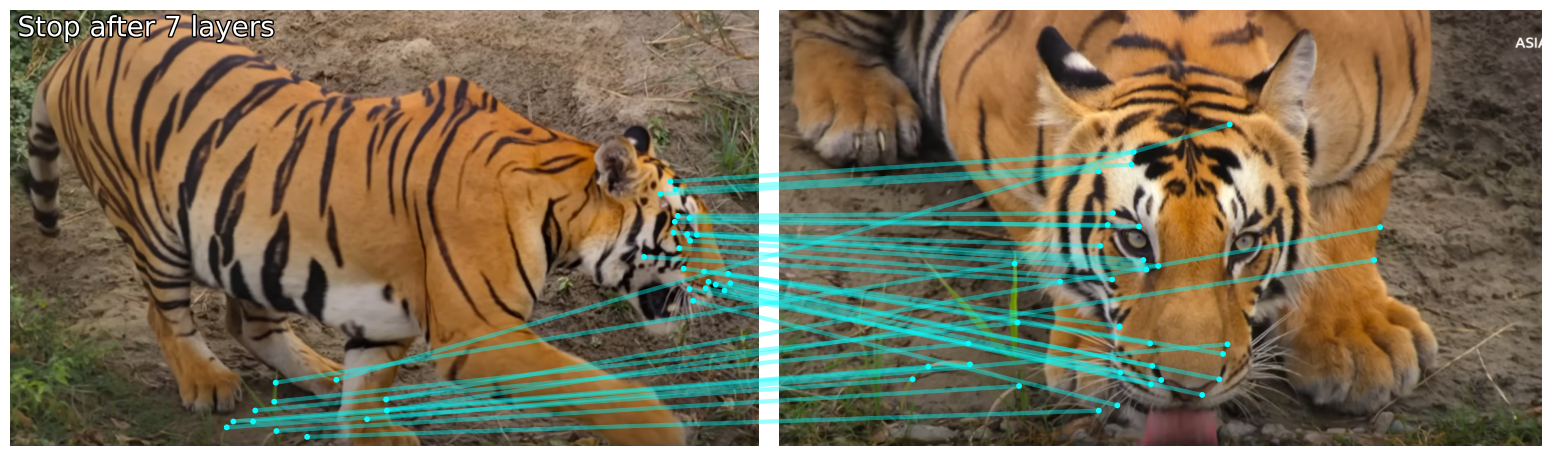

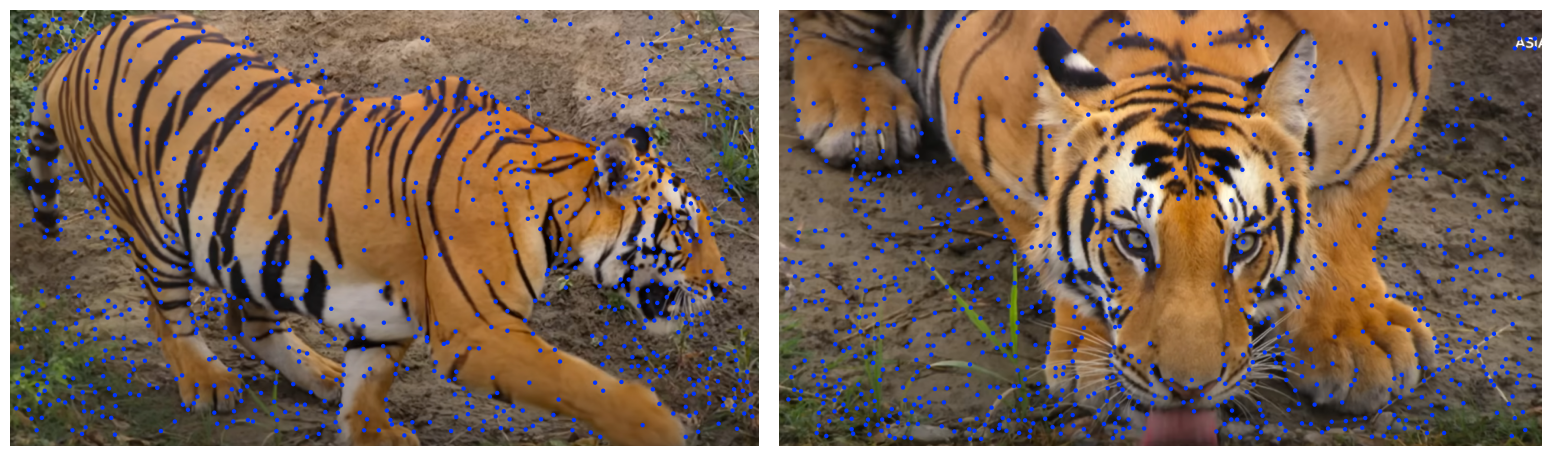

In [13]:
image0 = load_image("A1.png")
image1 = load_image("A2.png")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="cyan", lw=3, ps=10, a=0.4)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

# Inferences On Video

In [22]:
from PIL import Image
import numpy as np
def to_tensor(numpy_image_rgb):
    img_np = np.array(numpy_image_rgb).astype('float32') / 255.0  # Normalize
    return torch.from_numpy(img_np).permute(2, 0, 1)  # [H, W, C] → [C, H, W]


# Load and convert reference image
image0 = cv2.imread('A1.png', cv2.IMREAD_COLOR)  # BGR
image0_rgb = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)

def match_video_frame(image0_rgb,frame_rgb):
    
    image0_rgb = cv2.resize(image0_rgb, (1024,1024))
    frame_rgb = cv2.resize(frame_rgb, (1024,1024))


    # Convert both images to torch tensors normalized between 0-1
    image0_tensor = to_tensor(image0_rgb).to(device)
    image1_tensor = to_tensor(frame_rgb).to(device)

    # Feature extraction and matching
    feats0 = extractor.extract(image0_tensor)
    feats1 = extractor.extract(image1_tensor)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]


    # Extract matched keypoints
    kpts0, kpts1 = feats0["keypoints"], feats1["keypoints"]
    matches = matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    m_kpts0, m_kpts1 = m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy()

    # Convert frame_rgb to BGR for OpenCV visualization
    frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
    image0_bgr = cv2.cvtColor(image0_rgb, cv2.COLOR_RGB2BGR)
    

    # Draw keypoints on copies of both images
    ref_img_kp = image0_bgr.copy()
    frame_kp = frame_bgr.copy()
    
    for pt in m_kpts0:
        cv2.circle(ref_img_kp, (int(pt[0]), int(pt[1])), radius=3, color=(0, 0, 255), thickness=-1)
    
    for pt in m_kpts1:
        cv2.circle(frame_kp, (int(pt[0]), int(pt[1])), radius=3, color=(0, 0, 255), thickness=-1)

    # Concatenate side-by-side
    vis = cv2.hconcat([ref_img_kp, frame_kp])

    return vis  # NumPy array, shape [H, W, 3] in BGR format (OpenCV standard)



In [23]:
import cv2
from tqdm.auto import tqdm
from IPython.display import clear_output



video_path = 'tiger.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
input_fps = cap.get(cv2.CAP_PROP_FPS)
width  = 1024#int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = 1024#int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Output video writer (doubled width for side-by-side display)
output_fps = input_fps #/ 5
out = cv2.VideoWriter('output_matched.mp4', cv2.VideoWriter_fourcc(*'mp4v'), output_fps, (width * 2, height))

frame_counter = 0
# tqdm loop for progress tracking
for _ in tqdm(range(total_frames), desc="Processing frames"):
    ret, frame = cap.read()
    if not ret:
        break

    # if frame_counter % 5 != 0:
    #     frame_counter += 1
    #     continue  # skip non-matching frames

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    try:
        matched_vis = match_video_frame(image0_rgb, frame_rgb)
        out.write(matched_vis)
    except Exception as e:
        print(f"⚠️ Error on frame {frame_counter}: {e}")

    frame_counter += 1

cap.release()
out.release()
print("✅ Video saved as output_matched.mp4")

Processing frames:   0%|          | 0/4766 [00:00<?, ?it/s]

✅ Video saved as output_matched.mp4


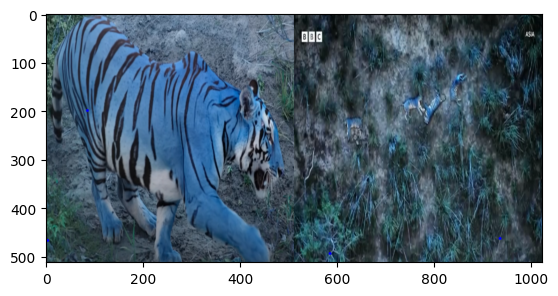

In [23]:
plt.imshow(matched_vis)

In [21]:
matched_vis = match_video(image0_rgb, frame_rgb, frame_counter)